In [269]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pyperclip

In [270]:
dt = 0.1
s  = ctl.TransferFunction.s

In [271]:
G = 1/(s**2 + 2*s)
C = (21.9543820023537*s + 64.585390060199)/(1.0*s + 5.35662298681269)

G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([21.954382  , 64.58539006]), array([ 1.        ,  7.35662299, 32.66762798, 64.58539006]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [272]:
G_z = ctl.c2d(G, dt, method='zoh')
G_z

TransferFunction(array([0.00468269, 0.00438077]), array([ 1.        , -1.81873075,  0.81873075]), 0.1)

In [273]:
C_z = ctl.c2d(C, dt, method='tustin')
C_z

TransferFunction(array([ 19.86356899, -14.76940562]), array([ 1.        , -0.57749713]), 0.1)

In [274]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([ 0.0930149 ,  0.01785729, -0.06470143]), array([ 1.        , -2.30321298,  1.88689983, -0.53751609]), 0.1)

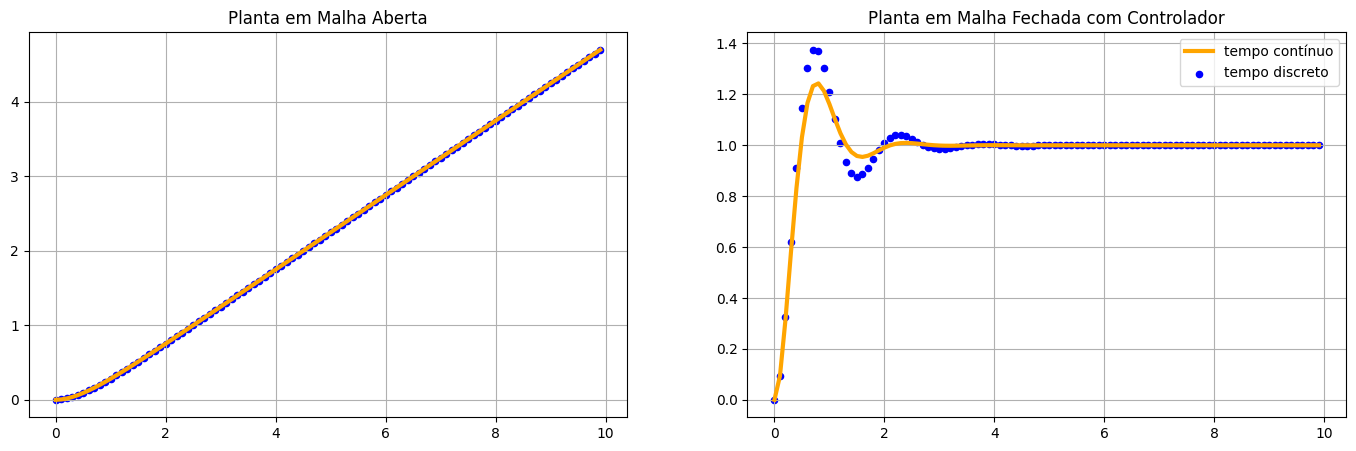

In [275]:
tData = np.arange(0, 10, dt)
plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
time, continuous = ctl.step_response(G, T=tData)
time, digital    = ctl.step_response(G_z, T=tData)
plt.scatter(time, continuous, color='blue', s=20, label='tempo discreto')
plt.plot(time, digital, color='orange', linewidth=3, label='tempo contínuo')
plt.title('Planta em Malha Aberta')
plt.grid()

plt.subplot(1, 2, 2)
time, continuous = ctl.step_response(G_feedback, T=tData)
time, digital    = ctl.step_response(G_z_feedback, T=tData)
plt.plot(time, continuous, color='orange', linewidth=3, label='tempo contínuo')
plt.scatter(time, digital, color='blue', s=20, label='tempo discreto')
plt.title('Planta em Malha Fechada com Controlador')
plt.legend()
plt.grid()

# DIGITALIZANDO O SISTEMA
- Preparando as funções que permitem digitalizar a função de transferência em transformada $Z$
    - **printDigital**: Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada
    - **compute**: aplica a função digitalizada a partir dos estados anteriores

- Estados anteriores
    - Y[0], Y[1], Y[2] ... se referem aos estados $Y_n$ (saída atual), $Y_{n-1}$ (penúltima saída), $Y_{n-2}$ (antipenúltima saída)

In [276]:
def getFraction(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    num = [float(val) for val in num]
    den = [float(val) for val in den]
    return (num, den) 


num, den = getFraction(G_z)
print(f'num -> xSize={len(num)}')
print(f'den -> ySize={len(den)}')

num -> xSize=2
den -> ySize=3


In [277]:
def printDigital(num, den):
    out = ''
    
    for i in range(0, len(num)): 
        out += f'Xn[{i}]*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Yn[{i}]*({-1*den[i]:.6f}) + '
    
    out = out.replace('X_n0', 'X_n')[:-3]
    print('Y[0] =', out)
    pyperclip.copy(out + ';')


printDigital(num, den)

Y[0] = Xn[0]*(0.004683) + Xn[1]*(0.004381) + Yn[1]*(1.818731) + Yn[2]*(-0.818731)


In [278]:
class Controller:
    def __init__(self, num, den, dt=0.05, bounds=None):
        self.bounds = bounds
        self.num = num
        self.den = den
        self.dt = dt
        self.Xn = np.zeros_like(self.num)
        self.Yn = np.zeros_like(self.den)

    def compute(self):
        out = 0.0

        for i in range(0, len(self.num)):
            out += self.Xn[i]*(self.num[i])
        
        for i in range(1, len(self.den)):
            out += self.Yn[i]*(-1*self.den[i])

        return out

    def update(self, input):
        for n in range(len(self.num)-1, 0, -1):
            self.Xn[n] = self.Xn[n-1]

        for n in range(len(self.den)-1, 0, -1):
            self.Yn[n] = self.Yn[n-1]
        
        self.Xn[0] = input
        output = self.compute()

        if self.bounds and output < self.bounds[0]:
            output = self.bounds[0]
        
        if self.bounds and output > self.bounds[1]:
            output = self.bounds[1]
        
        self.Yn[0] = output
        return self.Yn[0]
    
    def control(self, input, setpoint):
        return self.update(setpoint - input)
    
    def reset(self, val=0):
        self.Xn = val*np.ones_like(self.num)
        self.Yn = val*np.ones_like(self.den)
    

system = Controller(num, den, dt)

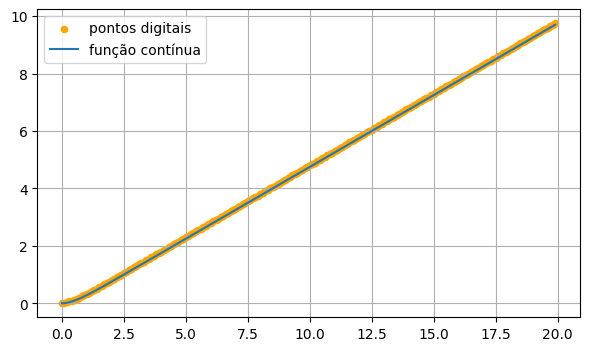

In [279]:
time = np.arange(0, 20, dt)
digital = [system.update(1) for t in time]
time, continuous = ctl.step_response(G, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

# DIGITALIZANDO O CONTROLADOR
- Comparando os dados contínuo e digital de forma gráfica através de um step

In [280]:
num, den = getFraction(C_z)
printDigital(num, den)

controller = Controller(num, den) 

Y[0] = Xn[0]*(19.863569) + Xn[1]*(-14.769406) + Yn[1]*(0.577497)


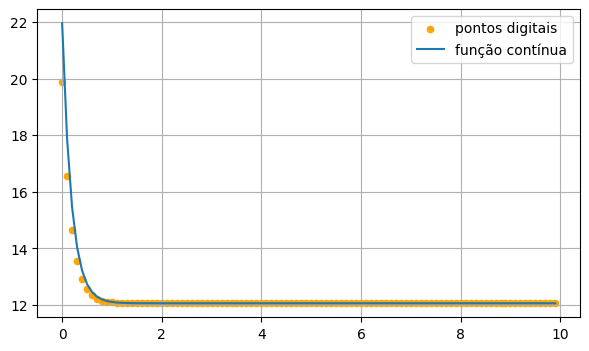

In [281]:
time = np.arange(0, 10, dt)
digital = [controller.control(input=1, setpoint=2) for t in time]
time, continuous = ctl.step_response(C, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

# SIMULANDO SISTEMA
- O controlador envia um sinal $out$ para a planta, que gera um outro sinal, que é comparado com o setpoint e enviado de novo ao controlador

In [282]:
num, den = getFraction(G_z)
system = Controller(num, den, dt)

num, den = getFraction(C_z)
controller = Controller(num, den, dt, bounds=(-100, 200))

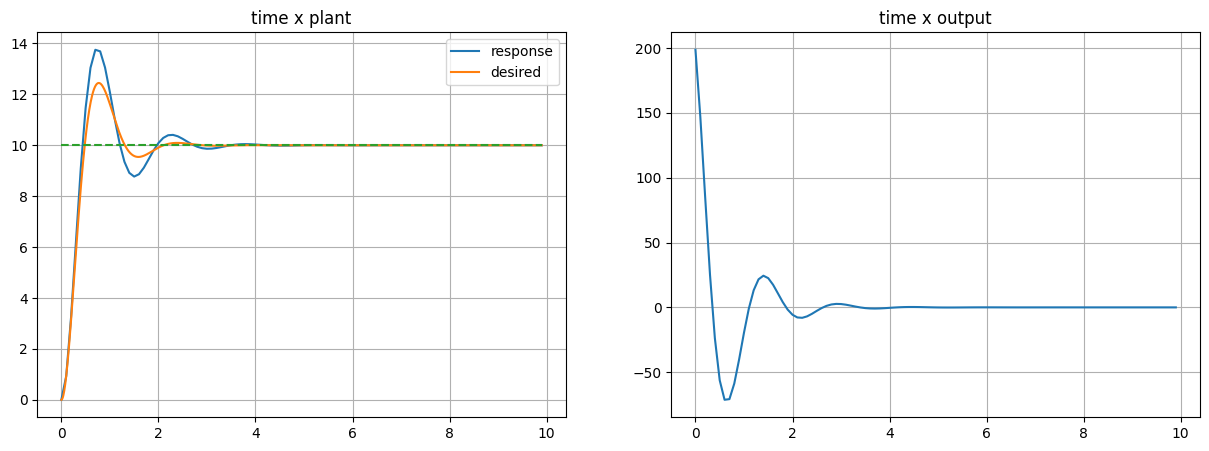

In [283]:
setpoint = 10
output   = 0
tData = []
xData = []
yData = []

for time in np.arange(0, 10, dt):
    input  = system.update(output)
    output = controller.control(input, setpoint)

    tData.append(time)
    xData.append(input)
    yData.append(output)


time = np.linspace(0, tData[-1], 1000)
time, desired = ctl.step_response(setpoint*G_feedback, T=time)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(tData, xData, label='response')
plt.plot(time, desired, label='desired')
plt.plot(tData, [setpoint for i in tData], '--')
plt.title('time x plant')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(tData, yData)
plt.title('time x output')
plt.grid()